# Simple Applications

## Bikeway Obstacle Detection

The goal is to first detect the presence of the obstacle and to tell us where it is so the user can navigate.

In [13]:
import os
import cv2
from PIL import Image, ImageFilter, ImageDraw, ImageOps, ImageEnhance, ImageFont
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage import measure
from sklearn.cluster import KMeans, MiniBatchKMeans

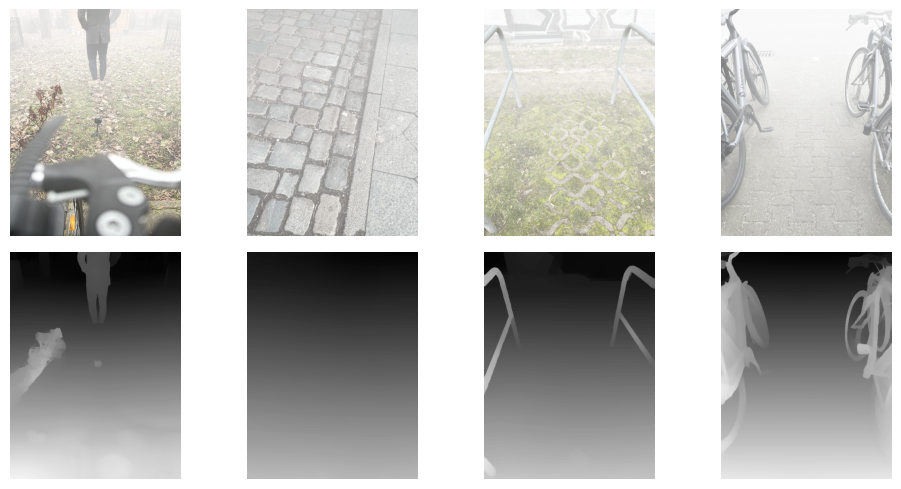

In [14]:
image1 = Image.open('data/processed/obstacle_detection_1.png').convert('RGBA')
image2 = Image.open('data/processed/obstacle_detection_2.png').convert('RGBA')
image3 = Image.open('data/processed/obstacle_detection_3.png').convert('RGBA')
image4 = Image.open('data/processed/obstacle_detection_4.png').convert('RGBA')

_,_,_,image1_d = image1.split()
_,_,_,image2_d = image2.split()
_,_,_,image3_d = image3.split()
_,_,_,image4_d = image4.split()

fig, axes = plt.subplots(2, 4, figsize=(10,5))
axes[0,0].imshow(image1)
axes[0,1].imshow(image2)
axes[0,2].imshow(image3)
axes[0,3].imshow(image4)
axes[1,0].imshow(image1_d, cmap='gray')
axes[1,1].imshow(image2_d, cmap='gray')
axes[1,2].imshow(image3_d, cmap='gray')
axes[1,3].imshow(image4_d, cmap='gray')

for row in axes:
    for ax in row:
        ax.axis('off')

plt.tight_layout()
plt.show()

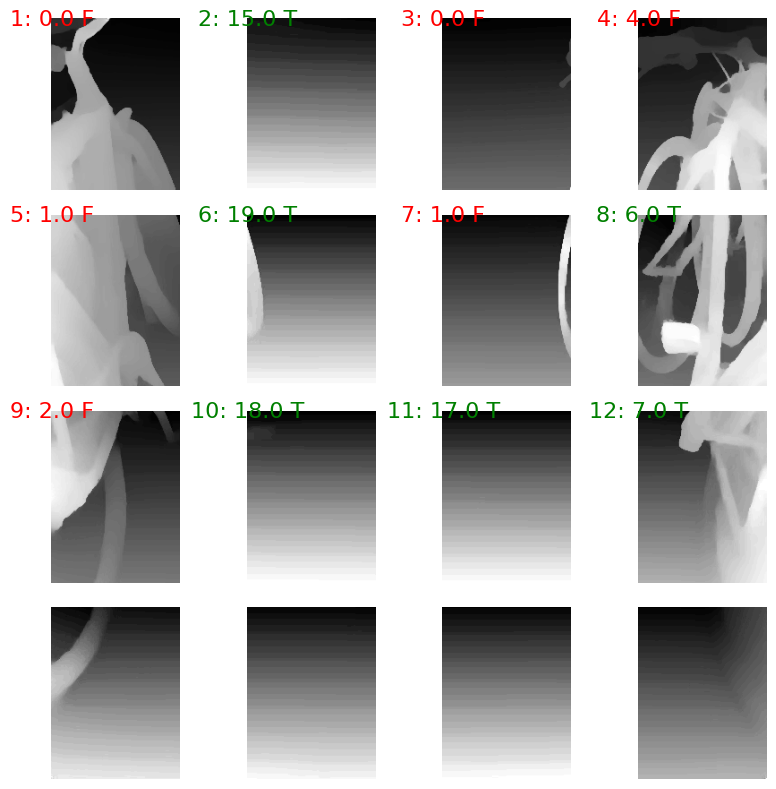

Obstacle regions: [False, True, False, False, False, True, False, True, False, True, True, True]


In [15]:
def split_image(image, num_rows, num_cols):
    width, height = image.width, image.height
    region_width = width // num_cols
    region_height = height // num_rows
    regions = []
    for row in range(num_rows):
        for col in range(num_cols):
            x1 = col * region_width
            y1 = row * region_height
            x2 = (col + 1) * region_width
            y2 = (row + 1) * region_height
            region = image.crop((x1, y1, x2, y2))
            regions.append(region)

    return regions

def check_obstacle_presence(region, threshold_factor):
    gray_region = region.convert("L")
    pixels = gray_region.getdata()
    threshold = np.max(pixels) - 5 #based on the lightest color, tolerance of 5
    white_pixels = sum(1 for pixel in pixels if pixel >= threshold)
    total_pixels = len(pixels)
    presence_percentage = round((white_pixels / total_pixels) * 100,0)
    if presence_percentage > 5:
        is_obstacle = True
    else:
        is_obstacle = False
    return is_obstacle, presence_percentage
    
regions = split_image(image4_d, 4, 4)

obstacle_regions = []
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for idx, region in enumerate(regions, start=1):
    row = (idx - 1) // 4
    col = (idx - 1) % 4
    axes[row, col].axis("off")

    if idx not in [13, 14, 15, 16]: 
        is_obstacle, presence_percentage = check_obstacle_presence(region, 200)
        obstacle_regions.append(is_obstacle)
        text = f"{idx}: {presence_percentage} {'T' if is_obstacle else 'F'}"
        text_color = "green" if is_obstacle else "red"
        axes[row, col].text(0.5, 0.5, text, color=text_color, fontsize=16, ha="center", va="center")

    # Add the original depth image as foreground
    axes[row, col].imshow(region, cmap="gray")

plt.tight_layout()
plt.show()

print("Obstacle regions:", obstacle_regions)

## Paint Matching and Estimation

We want to estimate the color of a digital image to a custom paint we have.

In [29]:
paint_map = {
    "Titanium White": (254, 254, 254),
    "Lemon Yellow": (255, 247, 0),
    "Medium Yellow": (255, 209, 0),
    "Orange Yellow": (255, 159, 0),
    "Vermilion": (255, 92, 0),
    "Crimson": (239, 41, 41),
    "Rose": (223, 71, 89),
    "Carmine": (210, 30, 72),
    "Purple": (165, 0, 165),
    "Lavender": (142, 87, 224),
    "Violet": (70, 35, 105),
    "Ultramarine Blue": (0, 0, 255),
    "Sky Blue": (0, 153, 255),
    "Cyan Blue": (0, 225, 255),
    "Turquoise Blue": (0, 179, 170),
    "Pthalo Green": (0, 128, 0),
    "Green": (0, 160, 0),
    "Olive Green": (60, 128, 49),
    "Lime Green": (128, 255, 0),
    "Yellow Ochre": (204, 119, 34),
    "Raw Sienna": (201, 143, 71),
    "Burnt Sienna": (174, 78, 40),
    "Raw Umber": (130, 102, 68),
    "Burnt Umber": (83, 52, 30),
    #"Grey": (128, 128, 128),
    #"Payne's Grey": (83, 89, 97),
    "Black": (0, 0, 0),
    "Gold": (212, 175, 55),
    "Silver": (192, 192, 192),
    "Bronze": (140, 120, 83),
    "Pearl White": (234, 224, 200),
    "Champagne": (248, 215, 142),
    "Skin Pink": (255, 194, 170),
    "Blush Pink": (255, 126, 121),
}

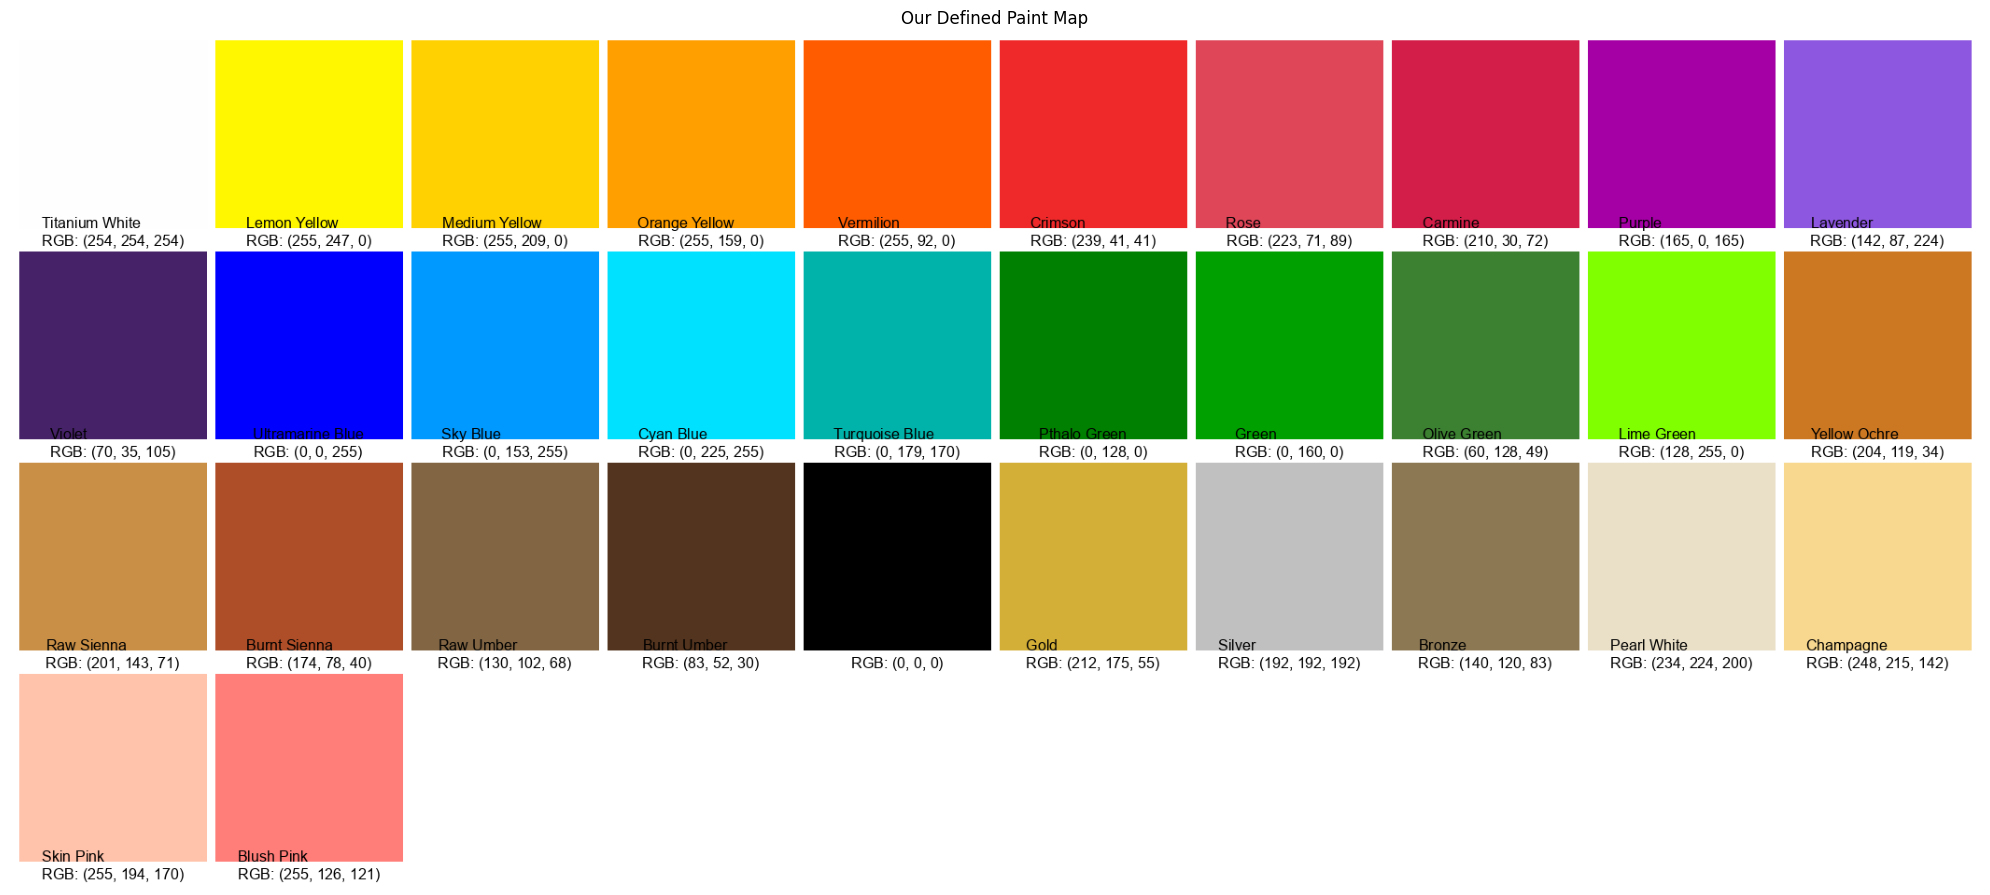

In [30]:
def create_paint_swatch(paint_map):
    swatch_size, padding, font_size = 200, 10, 16
    
    num_colors = len(paint_map)
    num_cols = 10
    num_rows = (num_colors + num_cols - 1) // num_cols
    
    swatch_width = num_cols * (swatch_size + padding) + padding
    swatch_height = num_rows * (swatch_size + padding + font_size) + padding
    
    swatch = Image.new('RGB', (swatch_width, swatch_height), (255, 255, 255))
    draw = ImageDraw.Draw(swatch)
    font = ImageFont.truetype("resources/fonts/arial.ttf", font_size)
    
    for i, (color_name, color_rgb) in enumerate(paint_map.items()):
        row = i // num_cols
        col = i % num_cols
        x = col * (swatch_size + padding) + padding
        y = row * (swatch_size + padding + font_size) + padding
        
        draw.rectangle((x, y, x+swatch_size, y+swatch_size), fill=color_rgb)
        
        text_x = x + swatch_size/2
        text_y = y + swatch_size + padding/2
        text = f"{color_name}\nRGB: {color_rgb}"
        draw.text((text_x, text_y), text, font=font, fill=(0, 0, 0), anchor="mm")
    
    return swatch

swatch = create_paint_swatch(paint_map)
fig = plt.figure(figsize=(20, 10))
plt.imshow(swatch)
plt.title("Our Defined Paint Map")
plt.axis("off")
plt.tight_layout()

In [31]:
def map_rgb_to_custom_paint(rgb, paint_map):
    rgb_array = np.array(rgb)
    distances = np.sqrt(np.sum((np.array(list(paint_map.values())) - rgb_array)**2, axis=1))
    closest_index = np.argmin(distances)
    paint_name = list(paint_map.keys())[closest_index]
    return paint_name, np.array(paint_map[paint_name])

def convert_image_to_paint(input_image, paint_map, sample):
    image = cv2.imread(input_image)
    h, w, _ = image.shape
    
    if sample:
        h = int(h * 0.25)
        w = int(w * 0.25)
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)

    new_image = np.zeros_like(image)
    used_paints = {}
    for i in range(h):
        for j in range(w):
            paint_name, paint_color = map_rgb_to_custom_paint(image[i, j], paint_map)
            new_image[i, j] = paint_color
            if paint_name:
                key = paint_name
                used_paints[key] = used_paints.get(key, 0) + 1

    return new_image, used_paints

def generate_linearts(new_image, paint_map):
    gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    lineart = cv2.bitwise_not(edges)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    lineart_numbers = np.full_like(new_image, 255)

    for x in range(0, new_image.shape[0], 10):
        for y in range(0, new_image.shape[1], 10):
            color, _ = map_rgb_to_custom_paint(new_image[x, y], paint_map)
            color_label = list(paint_map.keys()).index(color)
            #cv2.putText(lineart, str(color_label + 1), (y, x), font, font_scale, (128, 128, 128), font_thickness, cv2.LINE_AA)
            cv2.putText(lineart_numbers, str(color_label + 1), (y, x), font, font_scale, (128, 128, 128), font_thickness, cv2.LINE_AA)

    return lineart, lineart_numbers

def create_paint_legend(used_colors):
    swatch_size, padding, font_size = 200, 10, 16    
    num_colors = len(used_colors)
    num_cols = 6
    num_rows = (num_colors + num_cols - 1) // num_cols
    
    swatch_width = num_cols * (swatch_size + padding) + padding
    swatch_height = num_rows * (swatch_size + padding + font_size) + padding
    
    swatch = Image.new('RGB', (swatch_width, swatch_height), (255, 255, 255))
    draw = ImageDraw.Draw(swatch)
    font = ImageFont.truetype("resources/fonts/arial.ttf", font_size)
    
    total_usage = sum(used_colors.values())
    
    for i, color_name in enumerate(used_colors):
        color_rgb = paint_map[color_name]
        color_usage = used_colors[color_name]
        usage_percentage = (color_usage / total_usage) * 100
        row = i // num_cols
        col = i % num_cols
        x = col * (swatch_size + padding) + padding
        y = row * (swatch_size + padding + font_size) + padding
        draw.rectangle((x, y, x+swatch_size, y+swatch_size), fill=color_rgb)
        text_x = x + swatch_size/2
        text_y = y + swatch_size/2
        text = f"{color_name}\nRGB: {color_rgb}\nUsage: {usage_percentage:.0f}%"
        draw.text((text_x, text_y), text, font=font, fill=(0, 0, 0), anchor="mm")
    return swatch

In [32]:
input_image = 'data/external/sunflower_field.jpg'

new_image, used_paints = convert_image_to_paint(input_image=input_image, paint_map=paint_map, sample=True)
lineart, lineart_numbers = generate_linearts(new_image, paint_map)
swatch = create_paint_legend(used_paints)

cv2.imwrite('data/processed/sunflower_field_lineart_matched.png', new_image)
cv2.imwrite('data/processed/sunflower_field_lineart.png', lineart)
cv2.imwrite('data/processed/sunflower_field_lineart_numbers.png', lineart_numbers)
swatch.save('data/processed/sunflower_field_lineart_color_swatch.png')

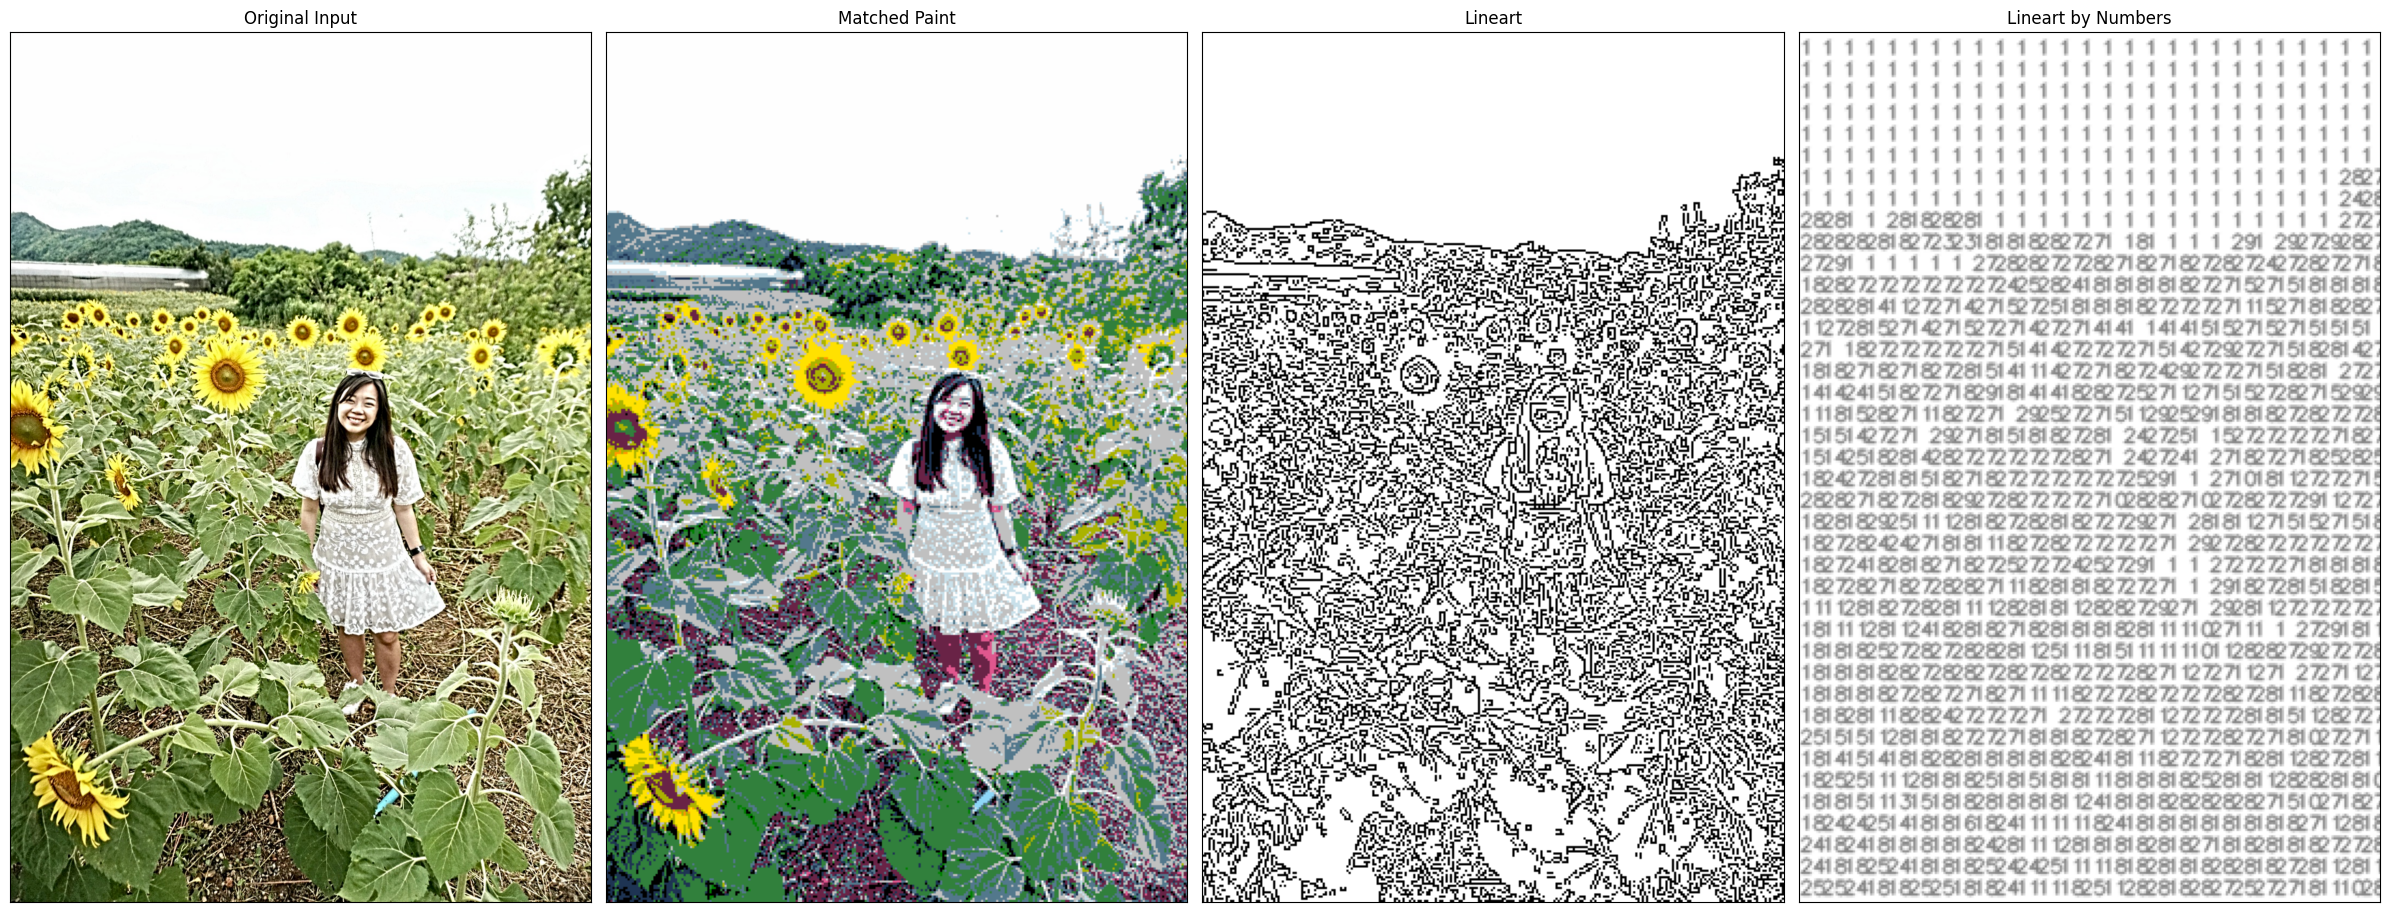

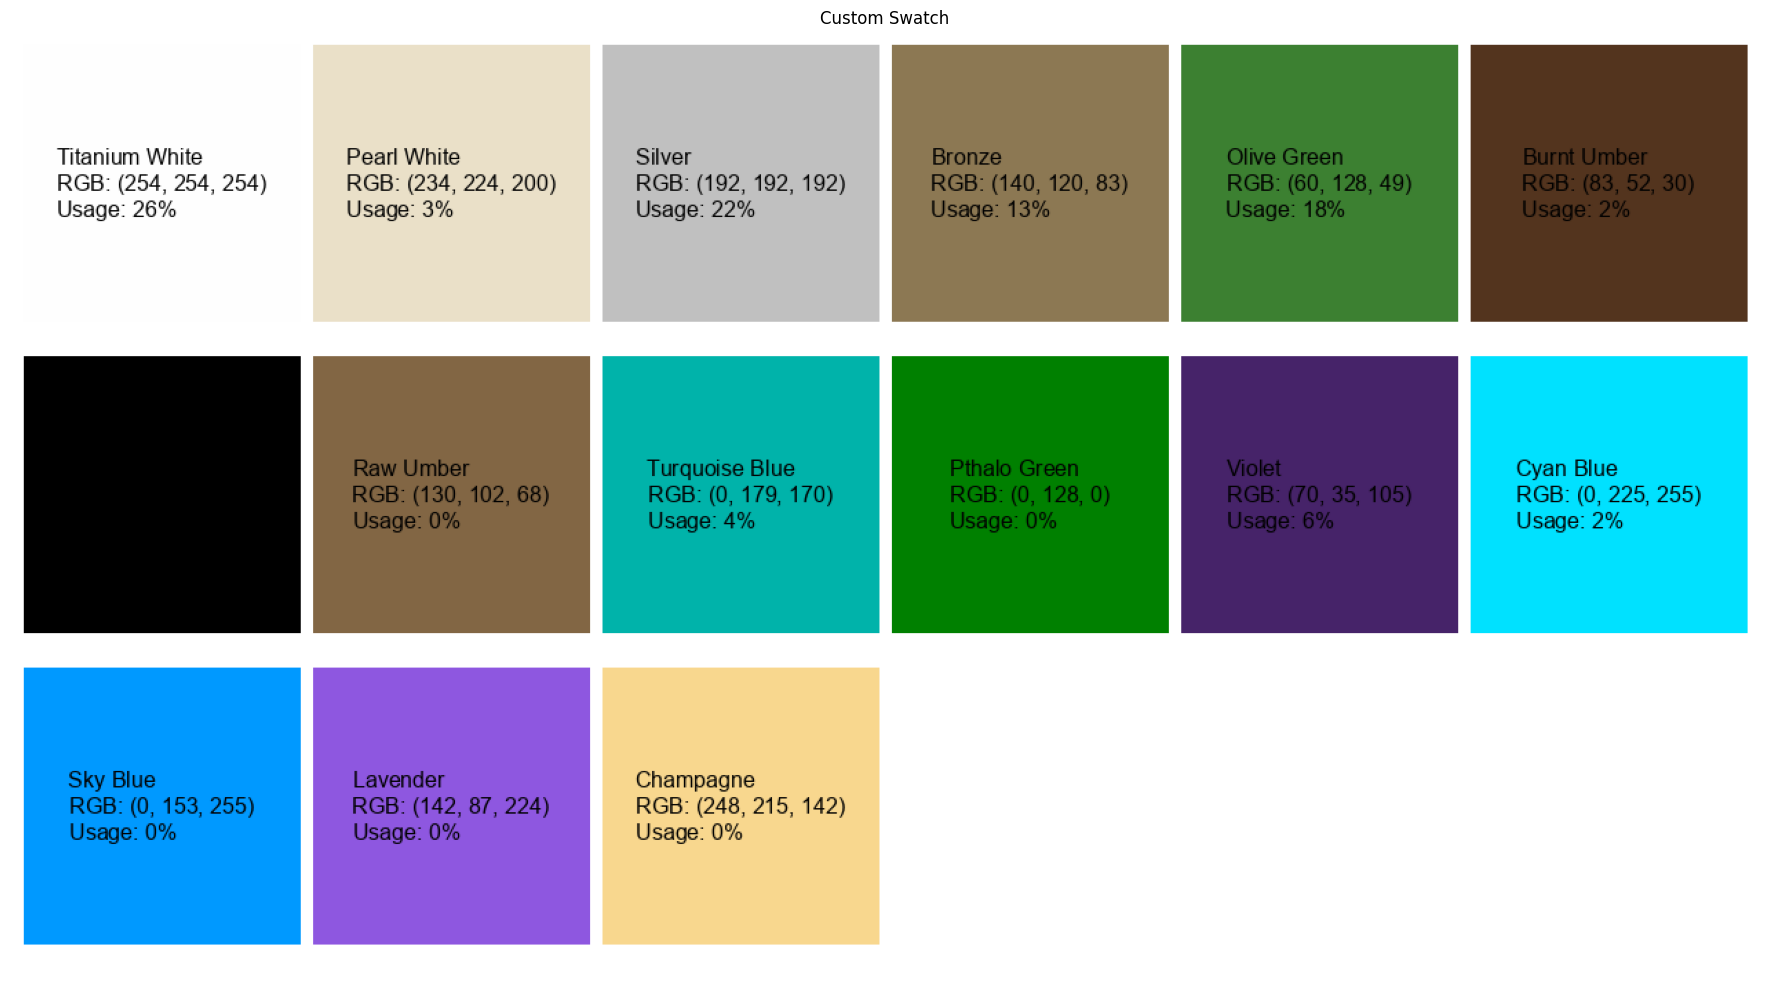

In [33]:
original = cv2.imread(input_image)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(24, 20))
axs[0].imshow(original)
axs[0].set_title('Original Input')
axs[1].imshow(new_image)
axs[1].set_title('Matched Paint')
axs[2].imshow(lineart, cmap='gray')
axs[2].set_title('Lineart')
axs[3].imshow(lineart_numbers, cmap='gray')
axs[3].set_title('Lineart by Numbers')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.imshow(swatch)
plt.title("Custom Swatch")
plt.axis("off")
plt.tight_layout()

## Dance Gestures

An in-depth analysis on dance gestures using image processing concepts found in this repository: [github.com/kayesokua/gestures](https://github.com/kayesokua/gestures/blob/main/summary.ipynb)